# P2P Model Italy

In this notebook we present the code for the ABM model adn the simulation we ran for Italy. The contents of this notebook were then generalised to the other 9 countries we ran simulations on. Indeed, all these notebooks presented the same coode for the models run, with the only difference being the country specific parameters inputted inn the model which can be found for each country in the file named 'Dataset_ABM.xlsx'

In [3]:
#Imports
from mesa import Model, Agent
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import SingleGrid,MultiGrid  
from mesa.datacollection import DataCollector
import random
import numpy as np
import pandas as pd
import time
import math as m
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 9, 'font.style': 'normal', 'font.family':'serif'})

## Defining Schelling
In this first section we ran the modified Schelling model described in the paper. It allows us to add a third class so as to represent the three income classes

In [2]:
def compute_mixity_index(model):
    agent_pij = np.array([agent.pij for agent in model.schedule.agents])
    M = np.sum(agent_pij)/model.schedule.get_agent_count()
    return M

In [3]:
class SchellingAgent(Agent):
    def __init__(self, pos, model, agent_type):

        super().__init__(pos,model)
        self.pos = pos
        self.type = agent_type
        self.utility = 0
        self.pij= 0

    def compute_utility(self):
        similar_to_me = 0
    
        neighbors = self.model.grid.neighbor_iter(self.pos)
        
        tot = len(list(neighbors))
        if tot == 0:
            self.pij = 1
        else:
            for neighbor in self.model.grid.neighbor_iter(self.pos,moore = True):
                if neighbor.type==self.type:
                    similar_to_me += 1
            self.pij = similar_to_me/tot
        
        if self.pij > self.model.threshold:
            self.utility = 1
        else:
            self.utility = 0
        
    def move(self):
        self.model.grid.move_to_empty(self)

    def step(self):
        self.compute_utility()
        if self.utility == 0:
            self.move()
        else:
            self.model.happy += 1
class ShellingModel(Model):
    def __init__(self, N,width,height, density, minority_hi,minority_li, threshold ):
        self.density = density
        self.minority_li = minority_li
        self.minority_hi = minority_hi
        self.threshold = threshold
        self.N = N  #accounting for the agents we don't create
        self.n_hi = N*minority_hi
        self.n_li = N*minority_li
        self.n_mi = N - (self.n_hi + self.n_li)
        self.grid = MultiGrid(width,height, True)
        self.schedule = RandomActivation(self) 
        self.running = True

        tot_hi = self.n_hi
        tot_li = self.n_li
        tot_mi = self.N - (self.n_hi + self.n_li)
        
        count = 0
        for cell in self.grid.coord_iter():
          if count < self.N:
            x = cell[1]
            y = cell[2] 
            if random.random() < self.density:
              agent_type = np.random.choice((0.5,1,1.5),p=[self.minority_li,1-(self.minority_li + self.minority_hi),self.minority_hi])
              count += 1
              if agent_type:
                    a = SchellingAgent((x,y), self, agent_type)
                    self.schedule.add(a)
                    self.grid.place_agent(a, (x, y))
        
            self.datacollector = DataCollector(
                {"mixity_index": compute_mixity_index},   # Model-leve vars: count of mixity agents
                {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1],"z": lambda a: a.type}) # Agent-level vars: For testing purposes, agent's individual x and y

        
    def step(self):
        self.happy = 0
        self.schedule.step()
        self.datacollector.collect(self) 
        if self.happy == self.grid.width * self.grid.height* self.density:
            self.running = False
        

## Defining P2P ABM Model

In [4]:
from collections import OrderedDict, defaultdict

# mypy
from typing import Dict, Iterator, List, Optional, Union, Type
from mesa.agent import Agent
from mesa.model import Model


# BaseScheduler has a self.time of int, while
# StagedActivation has a self.time of float
TimeT = Union[float, int]

#We modified the class of the Basescheduler so that it is able to recognize needy_prosumers function of our step function
class BaseScheduler:
    """Simplest scheduler; activates agents one at a time, in the order
    they were added.
    Assumes that each agent added has a *step* method which takes no arguments.
    (This is explicitly meant to replicate the scheduler in MASON).
    """

    def __init__(self, model: Model) -> None:
        """Create a new, empty BaseScheduler."""
        self.model = model
        self.steps = 0
        self.time: TimeT = 0
        self._agents: Dict[int, Agent] = OrderedDict()

    def add(self, agent: Agent) -> None:
        """Add an Agent object to the schedule.
        Args:
            agent: An Agent to be added to the schedule. NOTE: The agent must
            have a step() method.
        """

        if agent.unique_id in self._agents:
            raise Exception(
                f"Agent with unique id {repr(agent.unique_id)} already added to scheduler"
            )

        self._agents[agent.unique_id] = agent

    def remove(self, agent: Agent) -> None:
        """Remove all instances of a given agent from the schedule.
        Args:
            agent: An agent object.
        """
        del self._agents[agent.unique_id]

    def step(self) -> None:
        """Execute the step of all the agents, one at a time."""
        for agent in self.agent_buffer(shuffled=False):
            agent.step()
        self.steps += 1
        self.time += 1
        
    def needy_prosumers(self) -> None:
        """Execute the step of all the prosumers, one at time"""
        for agent in self.agent_buffer(shuffled=False):
            agent.needy_prosumers()

    def get_agent_count(self) -> int:
        """Returns the current number of agents in the queue."""
        return len(self._agents.keys())

    @property
    def agents(self) -> List[Agent]:
        return list(self._agents.values())

    def agent_buffer(self, shuffled: bool = False) -> Iterator[Agent]:
        """Simple generator that yields the agents while letting the user
        remove and/or add agents during stepping.
        """
        agent_keys = list(self._agents.keys())
        if shuffled:
            self.model.random.shuffle(agent_keys)

        for key in agent_keys:
            if key in self._agents:
                yield self._agents[key]

In [5]:
# Set of functions to keep track of the evolution of the three classes
def compute_P(model):
    Prosumers = 0
    for agent in model.schedule.agents:
        if agent.role == 'Prosumer':
            Prosumers += 1
    return Prosumers

def compute_C(model):
    Consumers = 0
    for agent in model.schedule.agents:
        if agent.role == 'Consumer':
            Consumers += 1
    return Consumers

def compute_D(model):
    Detached = 0
    for agent in model.schedule.agents:
        if agent.role =='Detached':
            Detached += 1
    return Detached

In [6]:
#The P2P Model
from typing_extensions import ParamSpecArgs
class P2PAgent(Agent):
  def __init__(self, pos, model, agent_type, agent_role):
    super().__init__(pos,model)

    self.pos = pos #agent's position in the gird
    self.model = model #model the agent is under
    self.type = agent_type #HIGH MIDDLE LOW INCOME
    self.role = agent_role #PROSUMER CONSUMER DETACHED
    self.w_subsidy = 1.038 #(from the Mundaca paper)
    self.w_env = 1.116 #(from the Mundaca paper)
    self.w_high_inc = 2.2 #weight of high income compared to mid level (based on data on European average income from  Kochhar paper)
    self.w_low_inc = 0.5 #weight of low income compared to mid level (based on data on European average income from  Kochhar paper)
    
    self.energy_consumption = self.model.avg_consumption # CHANGE HOW TO RESCALE CONSUMPTION BY WEALTH TYPE 
    self.running = True #DEFINING A STOP CONDITION
    
    self.savings = 0 #current savings of the agent
    self.coins = 0 # coins saved for threshold needed to invest in panel

    self.level = 0 # level of power currently reached by panel
    self.powers = [301, 320, 340, 440] #potential power levels of the panel watt/hour
    self.panel_power = self.powers[self.level] #current power of the panel in watt/hours
    self.n_panels = 0 # Number of panel owned by the agent

    self.solar_energy = 0 ## Energy produced by the solar panel of a prosumer
    self.savings_tresh = 0 # threshold needed to buy new panels 
    self.current_energy_need = 0 # energy still needed by the agent that is in the P2P grid

    self.detached_thresh = self.model.detached_thresh #Threshold needed for detached to become consumers according to peer pressure NEEDS CALIBRATION
    self.w1 = 1.28 # weight for prosumers in the detatched's neighbourhood (seenfreq from the Mundaca paper)
    self.w2 = 1.79 # weight for consumer in the detatched's neighbourhood (heardfreq from the Mundaca paper)

    self.probability_detached = self.model.probability_detached #Transition probability for detached
    self.prob = 0 #Transition probability for consumers and prosumers
    
  def compute_price(self):
    ''' function to compute the price of the energy in the P2P system'''
    tot_prosumers = compute_P(self.model)
    tot = self.model.N
    perc_prosumers = tot_prosumers/tot
    Grid_price = self.model.avg_price
    return Grid_price -(Grid_price*perc_prosumers)
    

  def check_neighbourhood(self):
    ''' function to check the status of the neighbours to see how many are prosumers and consumers'''
    neighbours = self.model.grid.get_neighborhood(self.pos,moore=True,include_center=False)
    n_prosumers = len([a for n in neighbours for a in self.model.grid.get_cell_list_contents(n) if a.role=='Prosumer'])
    n_consumers = len([a for n in neighbours for a in self.model.grid.get_cell_list_contents(n) if a.role=='Consumer'])
      
    var = 1+(self.w2-self.w1/self.w1)

    return (n_prosumers + var*n_consumers)>self.detached_thresh


  def calculate_threshold(self):
    ''' function to dynamically calcuate the threshold needed to invest as a function of the efficeincy of the panels and 
    of the wealth class (since diffrent classes insatll systems of different sizes)'''

    if self.role == 'Consumer':
      if self.type ==0.5:
        self.n_panels = 8
      elif self.type==1:
        self.n_panels = 15
      else:
        self.n_panels = 18
      thresh =self.n_panels*self.powers[self.level] * self.compute_price()
      return thresh
    elif self.role == 'Prosumer':
      thresh = (self.n_panels * self.powers[self.level+1] * self.compute_price())- (self.n_panels * self.powers[self.level] * self.compute_price())
      return thresh

  def solar_production(self):
    ''' calculates the energy produced by the prosumer's solar panel depending on the sun hour and the weather that day'''
    #Assigning the number of panel based on the wealth status
    if self.type == 0.5:
      self.n_panels = 8 # OTOVO
    elif self.type == 1:
      self.n_panels = 15 # OTOVO
    else:
      self.n_panels = 18 # OTOVO

    #Calculating the energy produced
    prod = self.model.sun_hours * self.panel_power *self.n_panels
      
    # Changing the production as a function of the weather
    if self.model.weather == 'Sunny':
      return prod
    elif self.model.weather == 'Cloudy':
      return prod/2
    else:
      return 0
    

  def distribute_energy(self, diff):
    ''' function to distribute the energy amongst neighbouring consumers and prousumers'''
      
    #Finding the neighbours that can receive energy
    neighbours = self.model.grid.get_neighborhood(self.pos,moore=True,include_center=False)

    #CHECK IF LIST COMPREHENSION BELOW WORKS
    #potential_consumers = [a[0] for n in neighbours if len(n)>0  for a in self.model.grid.get_cell_list_contents(n.pos) if a.role == 'Prosumer' or a.role == 'Consumer' and a.current_energy_need>0]
    potential_consumers = []
    for n in neighbours:
      for a in self.model.grid.get_cell_list_contents(n):
        if a.role == 'Prosumer' or a.role == 'Consumer':
          if a.current_energy_need>0:
            potential_consumers.append(a)


    #Caluclating energy to give each client and distributing it
    if len(potential_consumers)>0:
      energy_per_client = diff/len(potential_consumers)
      for i in potential_consumers:
        if i.current_energy_need < energy_per_client:
          i.coins+= (i.current_energy_need*self.model.avg_price) - (i.current_energy_need * self.compute_price())
          i.current_energy_need -= energy_per_client
        else:
          i.current_energy_need-=energy_per_client
          i.coins += (energy_per_client*self.model.avg_price) - (energy_per_client * self.compute_price())
    
  def compute_probability(self):
    '''function to compute the porbability of passing to another class'''
    p = np.exp(self.model.subsidy*self.w_subsidy + self.model.environmentalism*self.w_env)/(1+np.exp(self.model.subsidy*self.w_subsidy + self.model.environmentalism*self.w_env))
    return p

  def needy_prosumers(self):
    '''Checking the prosumers that need electricity from other prosumers and marking them as such'''

    if self.type == 0.5:
      self.energy_consumption = self.model.avg_consumption * self.w_low_inc
    elif self.type == 1.5:
      self.energy_consumption = self.model.avg_consumption * self.w_high_inc
    else:
      self.energy_consumption = self.model.avg_consumption

    self.current_energy_need = 0
    self.solar_energy = 0
    self.savings = 0

    if self.role == 'Prosumer':
      self.solar_energy = self.solar_production()
      diff = self.energy_consumption - self.solar_energy
        
      #If the self production is not more than the one needed the prosumer just saves money and is marked as needing more
      if diff>0:
        self.current_energy_need = diff

  def step(self):
    '''Step function to define what agents do at each step '''

    if self.type == 0.5:
      self.energy_consumption = self.model.avg_consumption *self.w_low_inc
    elif self.type == 1.5:
      self.energy_consumption = self.model.avg_consumption * self.w_high_inc
    else:
      self.energy_consumption = self.model.avg_consumption

    #Steps if Detached
    if self.role == 'Detached':
      self.coins = 0
      if self.check_neighbourhood():
        if np.random.random()<self.probability_detached: 
          self.role = 'Consumer'
     
    #Steps if Prosumer
    elif self.role == 'Prosumer':
      self.solar_energy = self.solar_production()
      diff = self.energy_consumption - self.solar_energy

      #If the self production exceeds the one needed the prosumer then can redistribute it
      if diff<0:
        diff = diff*-1
        self.distribute_energy(diff) # Distributing energy to the other neighbours connected
        self.savings+= ((self.energy_consumption*self.model.avg_price)-(self.energy_consumption* self.compute_price()))
        self.coins += self.savings
        if self.level <3:
          self.savings_tresh = self.calculate_threshold()
          if self.coins > self.savings_tresh:
            self.prob = self.compute_probability() #Computing probability based on welath status and education index
            if np.random.random()< self.prob: 
              self.level+=1
              self.panel_power = self.powers[self.level] #increase in power from investment
              self.coins-= self.savings_tresh
        else:
          self.panel_power = self.powers[self.level]
        
      elif diff>0:
        self.savings+= ((self.solar_energy*self.model.avg_price) - (self.solar_energy * self.compute_price()))
        self.coins += self.savings 
        if self.level <3:
          self.savings_tresh = self.calculate_threshold()
          if self.coins > self.savings_tresh:
            self.prob = self.compute_probability() #Computing probability based on welath status and education index
            if np.random.random() < self.prob: 
              self.level+=1
              self.panel_power = self.powers[self.level] # increase in power from investment
              self.coins-= self.savings_tresh
        else:
          self.panel_power = self.powers[self.level]
          
    #Steps if Consumer 
    elif self.role == 'Consumer':
      self.coins += self.savings
      self.savings_tresh = self.calculate_threshold()
      if self.coins > self.savings_tresh:
        self.prob = self.compute_probability() #Computing probability based on welath status and education index
        if np.random.random() < self.prob: 
          self.role = 'Prosumer'
          self.coins-= self.savings_tresh
      self.current_energy_need = self.energy_consumption


class P2PModel(Model):
  def __init__(self, N, width, height, agent_matrix, avg_consumption, sun_hours, weather_dist, role_dist, avg_price, subsidy, environmentalism,probability_detached,detached_thresh, index):
    self.N = N
    self.avg_consumption = avg_consumption
    self.grid = MultiGrid(width,height, True)
    self.schedule = BaseScheduler(self) 
    self.running = True
    self.role_dist = role_dist
    self.weather = 'start'
    self.sun_hours = sun_hours #Italy = 6.5
    self.weather_dist = weather_dist
    self.avg_price = avg_price
    self.subsidy = subsidy
    self.environmentalism = environmentalism
    self.probability_detached = probability_detached 
    self.detached_thresh = detached_thresh
    self.agent_matrix = agent_matrix[index]



    #CREATING THE AGENTS AND PLACING THEM BACK IN THE GRID
    agents = []
    for row in range(self.agent_matrix.shape[0]):
      for col in range(self.agent_matrix.shape[1]):
        x = row
        y = col
        if self.agent_matrix[row][col]==0.5:
          agent_type = 0.5
          agent_role = np.random.choice(("Prosumer","Consumer","Detached"),p=self.role_dist) #Initial [0.025,0.05,0.925]
          a = P2PAgent((x,y),self,agent_type,agent_role)
          agents.append(a)
        elif self.agent_matrix[row][col]==1:
          agent_type = 1
          agent_role = np.random.choice(("Prosumer","Consumer","Detached"),p=self.role_dist) 
          a = P2PAgent((x,y),self,agent_type,agent_role)
          agents.append(a)
        elif self.agent_matrix[row][col]==1.5:
          agent_type = 1.5
          agent_role = np.random.choice(("Prosumer","Consumer","Detached"),p=self.role_dist)
          a = P2PAgent((x,y),self,agent_type,agent_role)
          agents.append(a)

    #Adding Detatched first
    for d in agents:
      if d.role == 'Detached':
        self.schedule.add(d)
        self.grid.place_agent(d, d.pos)   

    #Adding consumers second
    for c in agents:
      if c.role == 'Consumer':
        self.schedule.add(c)
        self.grid.place_agent(c, c.pos) 
        
    #Adding Prosumers third
    for p in agents:
      if p.role == 'Prosumer':
        self.schedule.add(p)
        self.grid.place_agent(p, p.pos)


    
    self.datacollector = DataCollector(agent_reporters = {"electricity": lambda a: a.solar_energy,
                                                          'role': 'role',
                                                          'Social_class':'type',
                                                          'prob': lambda a: a.prob,
                                                          'coins':'coins',
                                                          'savings': 'savings'},
                                       
                        model_reporters = {"Number of Prosumers":compute_P,
                                           "Number of Consumers":compute_C,
                                           "Number of Detached":compute_D,
                                           'Weather': 'weather'})

  def step(self):
    self.weather = np.random.choice(('Sunny', 'Cloudy', 'Rainy'), p=self.weather_dist) # Italy Distribution : [0.63, 0.17, 0.20]
    self.schedule.needy_prosumers()
    self.schedule.step()
    self.datacollector.collect(self) 


## Running the Italy Model

In [7]:
##ITALY SCHELLING CHECKING CONVERGENCE
np.random.seed(8)
#population, width, height, density(0.8), high_income,low_income,gini_index
model = ShellingModel(5944,85,85, (0.84),0.18,0.35,0.325) 
start = time.time()
while model.running and model.schedule.steps < 100:
    model.step()
    
print(model.schedule.steps)
print(f"{time.time()-start}")
output = model.datacollector.get_model_vars_dataframe()
output.tail()

100
12.667644262313843


,mixity_index
95,0.750044
96,0.750044
97,0.750044
98,0.750044
99,0.750044


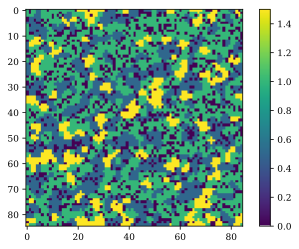

In [8]:
agent_matrix_ITA = np.zeros((model.grid.width, model.grid.height)) 

for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    #print(cell_content)
   
    if cell_content == []:
        agent_count= 0
        #print(agent_count)
    else:
        agent_count = float(cell_content[0].type)
        #print(agent_count)
    agent_matrix_ITA[x][y] = agent_count
    #print(agent_count)
plt.imshow(agent_matrix_ITA, interpolation='nearest')
plt.colorbar()
plt.show()

In [8]:
##ITALY SCHELLING FOR BATCH RUNNER

schelling_matrices = []
#population, width, height, density, high_income,low_income,gini_index

for i in tqdm(range(3)):
    model = ShellingModel(5944,85,85, (0.84),0.18,0.35,0.325) 
    start = time.time()
    while model.running and model.schedule.steps < 100:
        model.step()

    agent_matrix_ITA = np.zeros((model.grid.width, model.grid.height)) 
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell    
        if cell_content == []:
            agent_count= 0
        else:
            agent_count = float(cell_content[0].type)

        agent_matrix_ITA[x][y] = agent_count
    schelling_matrices.append(agent_matrix_ITA)


100%|█████████████████████████████████████████████| 3/3 [00:44<00:00, 14.92s/it]


In the cell below we ran the model with the parameters for italy and the Batch Runner routine. This allowed us to run the model with a range of values for those variable that needed such a procedure as we mentioned in the paper. The model run in itself is quite long (over 7 hours) so we also included a pickle file that can be imported by uncommenting the relevant cell so as to visualise the data if needed.

In [9]:
#BATCH RUNNER ITALY
from mesa.batchrunner import BatchRunner
#model_ITA = P2PModel(6000, 85, 85, agent_matrix_ITA, 3022,6.5,[0.63, 0.17, 0.20], [0.05,0.1,0.85], 0.0002153,0.3, 0.7) 

fixed_params ={'N':5944,
                'width':85,
                'height':85,
                'avg_consumption':4928,
                'sun_hours':6.5,
                'weather_dist':[0.63, 0.17, 0.20],
                'role_dist':[0.05,0.1,0.85],
                'avg_price':0.0002360,
                'subsidy':0.4,
                'environmentalism':0.69, 
               'agent_matrix':schelling_matrices }

variable_params = {'index':[0,1,2],
                   'probability_detached': np.arange(0.01,0.025,0.005),
                   'detached_thresh':np.arange(4,6,1)}


batch_run = BatchRunner(
    P2PModel,  
    variable_params, 
    fixed_params, 
    iterations=3, 
    max_steps=365, 
    model_reporters={"Model_Data_Collector": lambda m: m.datacollector.get_model_vars_dataframe(),
                     "Agent_Data_Collector": lambda m: m.datacollector.get_agent_vars_dataframe()}) # <- COLLECT STEP BY STEP DATA AGENT LEVEL VARS
                         
                                        #lambda m: m.datacollector.get_agent_vars_dataframe() the sotre directly the df for agent_vars or model_vars


# Run the experiments
batch_run.run_all()  # this can take a bit

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
54it [7:12:03, 480.06s/it]


In [1]:
#Visualising the df of all the Batch Runner results and saving it
run_data = batch_run.get_model_vars_dataframe()
#run_data.to_pickle('Italy_batch_runner_base.pkl') #Uncomment line to save data
run_data

In [4]:
# Uncomment contents of this cell to access data without the need to run the model
#This file being read is the uncompressed version of the zipped pickle found in the folder
#run_data = pd.read_pickle('Italy_batch_runner_base.pkl')

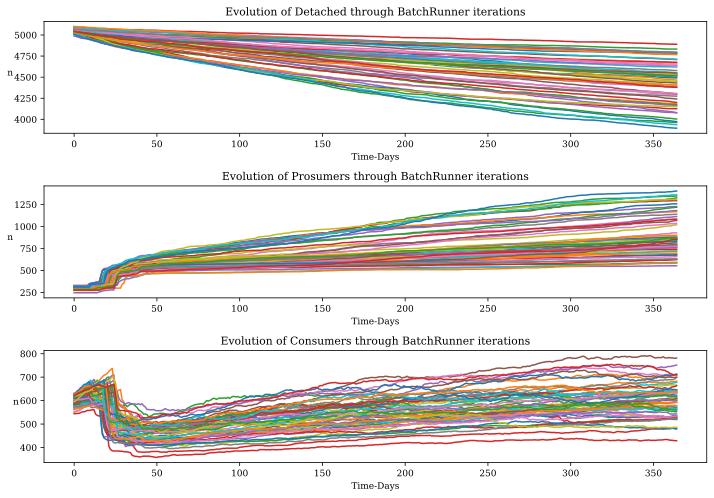

In [12]:
#FIRST PLOT, all runs no confidence bands
fig, axs = plt.subplots(3,1,figsize=(10,7))
info = ['Number of Detached','Number of Prosumers','Number of Consumers']
names = ['Detached','Prosumers','Consumers']
for i in range(3):
  ax = axs[i]
  for j in range(run_data.shape[0]):
    ax.set_title(f'Evolution of {names[i]} through BatchRunner iterations')
    ax.set_xlabel('Time-Days')
    ax.set_ylabel('n',rotation=0)
    ax.plot(run_data['Model_Data_Collector'][j][info[i]])
    ax.plot(run_data['Model_Data_Collector'][j][info[i]].mean(),color = 'red')
    #ax.legend(fancybox = True)

fig.tight_layout()
#plt.legend()
plt.show()

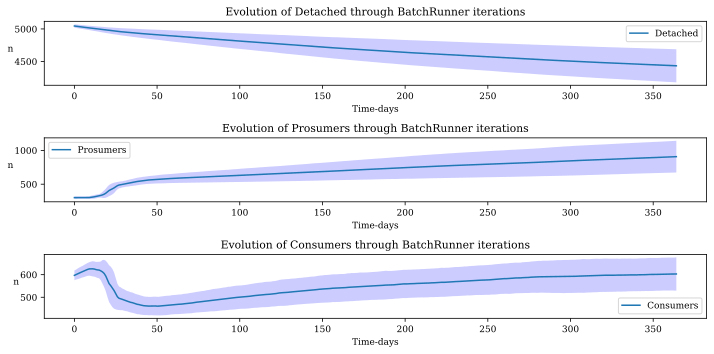

In [13]:
#SECOND PLOT with confidence bands
fig, axs = plt.subplots(3,1,figsize =(10,5))

info = ['Number of Detached','Number of Prosumers','Number of Consumers']
names = ['Detached','Prosumers','Consumers']
for i in range(3):
    ax = axs[i]
    ax.set_title(f'Evolution of {names[i]} through BatchRunner iterations')
    ax.set_xlabel('Time-days')
    ax.set_ylabel('n',rotation=0)
    d = pd.DataFrame()
    for j in range(run_data.shape[0]):
        d = d.append(pd.DataFrame(run_data['Model_Data_Collector'][j][info[i]]).T)
    ax.plot(np.mean(d,axis=0),label=names[i])
    ax.fill_between(np.arange(365),np.mean(d,axis=0)-np.std(d,axis=0),np.mean(d,axis=0)+np.std(d,axis=0),facecolor='blue',alpha=0.2)
    ax.legend(fancybox=True)


fig.tight_layout()
plt.legend()
plt.show()

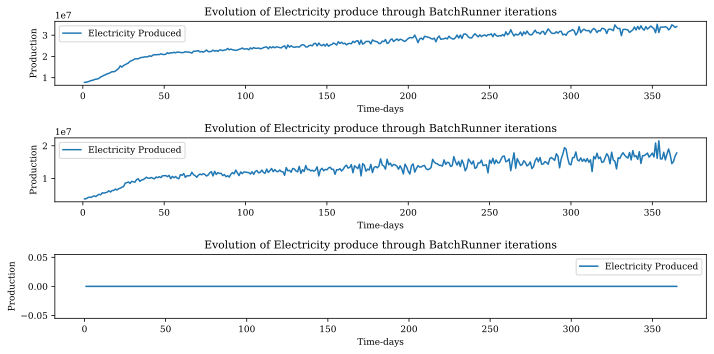

In [14]:
#PLOT ELECTRICITY (divided bewteen sunny,cloudy,rainy)
fig, axs = plt.subplots(3,1,figsize =(10,5))

names = ['Sunny','Cloudy']

for i in range(3):
    if i==0:
        ax = axs[i]
        ax.set_title(f'Evolution of Electricity produce through BatchRunner iterations')
        ax.set_xlabel('Time-days')
        ax.set_ylabel('Production',rotation=90)
        d = pd.DataFrame()
        for j in range(run_data.shape[0]):
            idx =np.array(run_data['Model_Data_Collector'][j]['Weather']=='Sunny')
            t = run_data['Agent_Data_Collector'][j]['electricity'].reset_index().groupby('Step')[['electricity']].sum()
            d = d.append(t.iloc[idx].T)
        ax.plot(np.mean(d,axis=0),label='Electricity Produced')
        #ax.fill_between(np.arange(t.iloc[idx].T.shape[1]),np.mean(d,axis=0)-np.std(d,axis=0),np.mean(d,axis=0)+np.std(d,axis=0),color='blue',alpha=0.2)
        ax.legend(fancybox=True)
    if i==1:
        ax = axs[i]
        ax.set_title(f'Evolution of Electricity produce through BatchRunner iterations')
        ax.set_xlabel('Time-days')
        ax.set_ylabel('Production',rotation=90)
        d = pd.DataFrame()
        for i in range(run_data.shape[0]):
            idx =np.array(run_data['Model_Data_Collector'][i]['Weather']=='Cloudy')
            t = run_data['Agent_Data_Collector'][i]['electricity'].reset_index().groupby('Step')[['electricity']].sum()
            d = d.append(t.iloc[idx].T)            
        ax.plot(np.mean(d,axis=0),label='Electricity Produced')
        #ax.fill_between(np.arange(365),np.mean(d,axis=0)-np.std(d,axis=0),np.mean(d,axis=0)+np.std(d,axis=0),color='blue',alpha=0.2)
        ax.legend(fancybox=True)
    if i==2:
        ax = axs[i]
        ax.set_title(f'Evolution of Electricity produce through BatchRunner iterations')
        ax.set_xlabel('Time-days')
        ax.set_ylabel('Production',rotation=90)
        d = pd.DataFrame()
        for i in range(run_data.shape[0]):
            idx =np.array(run_data['Model_Data_Collector'][i]['Weather']=='Rainy')
            t = run_data['Agent_Data_Collector'][i]['electricity'].reset_index().groupby('Step')[['electricity']].sum()
            d = d.append(t.iloc[idx].T)
        ax.plot(np.mean(d,axis=0),label='Electricity Produced')
        ax.plot(np.mean(d,axis=0)-np.std(d,axis=0),np.mean(d,axis=0)+np.std(d,axis=0))
        ax.legend(fancybox=True)


fig.tight_layout()
plt.legend()
plt.show()

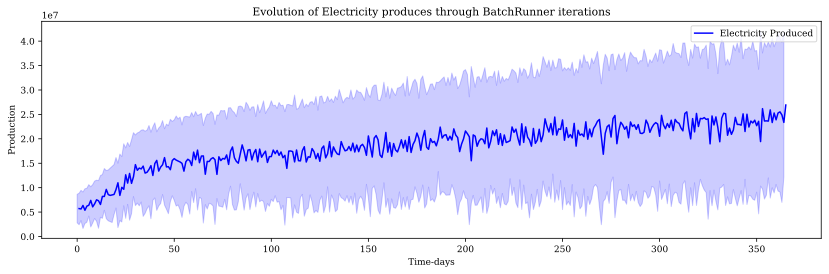

In [15]:
#PLOT ELECTRICITY OVERALL
fig, axs = plt.subplots(figsize =(14,4))

names = ['Sunny','Cloudy']

axs.set_title(f'Evolution of Electricity produces through BatchRunner iterations')
axs.set_xlabel('Time-days')
axs.set_ylabel('Production',rotation=90)
d = pd.DataFrame()
for j in range(run_data.shape[0]):
    d = d.append(run_data['Agent_Data_Collector'][j]['electricity'].reset_index().groupby('Step')[['electricity']].sum().T)
axs.plot(np.mean(d,axis=0),label='Electricity Produced',color='blue')
axs.fill_between(np.arange(365),np.mean(d,axis=0)-np.std(d,axis=0),np.mean(d,axis=0)+np.std(d,axis=0),color='blue',alpha=0.2)
axs.legend(fancybox=True)
plt.show()

In [16]:
#Calculating total electricity output
sums = []
for i in range(len(run_data['Agent_Data_Collector'])):
    sums.append(run_data['Agent_Data_Collector'][i]['electricity'].sum()/10**5)

print(f'mean electricity: {np.mean(sums)}')
print(f'std electricity: {np.std(sums)}')

mean electricity: 68202.41732476851
std electricity: 13817.726082734978
